<a href="https://colab.research.google.com/github/NataliaKurd/transformers_end_assignment/blob/main/transfomers_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfomers: Exploration of memorization in Large Language Models

**Group members:**
- Natalia Kurdanova
- Sean
- Sjardi
- Jefry

In [1]:
import numpy as np
import pandas as pd
import tqdm
import re

from matplotlib import pyplot as plt
from collections import Counter

from transformers import GPTNeoForCausalLM, GPT2Tokenizer, GenerationConfig
import torch

import nltk
from nltk.corpus import stopwords

## 0. Download data

In [2]:
# clone git repository with the data
!git clone https://github.com/ethz-spylab/lm_memorization_data

Cloning into 'lm_memorization_data'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 27 (delta 3), reused 20 (delta 2), pack-reused 0
Receiving objects: 100% (27/27), 359.03 KiB | 3.78 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Filtering content: 100% (9/9), 564.10 MiB | 41.09 MiB/s, done.


In [3]:
data_p = np.load('lm_memorization_data/data/prompts_100.npy')
data_c = np.load('lm_memorization_data/data/counts_100.npy')

In [4]:
data_p.shape, data_c.shape

((56000, 100), (56000,))

## 1. Data exploration

In [ ]:
data_prompts = data_p.copy()
data_counts = data_c.copy()

In [ ]:
vocab = GPT2Tokenizer.from_pretrained('EleutherAI/gpt-neo-125m')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
decoded_data = []

for ids in tqdm.tqdm(data_prompts):
  decoded_data.append(vocab.decode(ids, skip_special_tokens=True))

100%|██████████| 56000/56000 [02:10<00:00, 428.88it/s]


In [ ]:
decoded_data = np.asarray(decoded_data)
decoded_data[100]

' dream about now?" "Little bit smaller girl." "Looks a little bit like you." "In a moonpie bikini." "Any chance you didn\'t hear that?" "Listen, I apologize." "I gotta run to the toilet." "My stomach ain\'t felt this bad since I had them fish sticks out of the vending machine at the Phillips 66." "It\'s down the hall, the first door on your left." "I appreciate it." "Oh, damn." " Is everything all'

### 1.1. Data visualization

First we explor the data set with sequences of length 100. We will look at most frequent sequences and words.

In [ ]:
# top the most frequent sequences
sorted_freq = np.argsort(data_counts)[-50:]

In [ ]:
data_counts[sorted_freq]

array([245699, 246544, 247424, 248508, 249450, 249894, 250667, 251787,
       251891, 253544, 253769, 256223, 257110, 257909, 258944, 259652,
       261218, 262199, 262274, 262881, 264928, 265081, 265894, 266475,
       266757, 266757, 266757, 266765, 266769, 269774, 272606, 274149,
       274202, 276730, 278745, 280176, 282493, 285062, 285376, 287200,
       288003, 290078, 292759, 294089, 294767, 295147, 297177, 298570,
       298677, 301225])

In [ ]:
# We have duplicates because we do not have special tokens in the decoded data
print('Number of duplicated sequences: ', len(decoded_data) - len(set(decoded_data)))

Number of duplicated sequences:  28


In [ ]:
# clean the data
cleaned_data = []
regex_string = r'[^\w\s]|[\n]|(\s)(i|1|2|0|if|by|are|at|is|a|an|and|the|of|to|and|in|is|or|for|you|he|she|it|this|that|with|be|on)(\s)'

for sequence in tqdm.tqdm(decoded_data):
  sequence = sequence.lower()
  cleaned_data.append(re.sub(regex_string, ' ', sequence))

100%|██████████| 56000/56000 [00:07<00:00, 7583.03it/s] 


In [ ]:
cleaned_data = np.asarray(cleaned_data)
cleaned_data[100]

' dream about now    little bit smaller girl    looks little bit like you    in moonpie bikini    any chance didn t hear that    listen  apologize    i gotta run the toilet    my stomach ain t felt bad since had them fish sticks out the vending machine the phillips 66    it s down hall  first door your left    i appreciate it    oh  damn     everything all'

In [ ]:
df = pd.DataFrame(cleaned_data)
df['Length'] = df[0].apply(len)
df['Word_Count'] = df[0].str.split().apply(len)

In [ ]:
df.sort_values(by='Word_Count', ascending=False).head(15)

,0,Length,Word_Count
46377,8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8...,200,100
50409,00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 ...,300,100
54428,000 000 000 000 000 000 000 000 000 000 000 0...,400,100
55149,drip drip drip drip drip drip drip drip drip ...,500,100
27381,bethlehem afp getty images donald trump s int...,626,90
27218,palestinian leader the presidential palace th...,625,88
27708,io stampa presidenza della via getty donald tr...,595,85
29372,germany 1949 1990 estonia finland france ge...,584,81
19949,damien hinds damien hinds sacked as education...,466,81
47689,not support inline frames is currently config...,532,79


In [ ]:
df.describe()

,Length,Word_Count
count,56000.000000,56000.000000
mean,235.321643,27.779107
std,102.952675,19.678454
min,34.000000,0.000000
25%,151.000000,11.000000
50%,219.000000,25.000000
75%,312.000000,43.000000
max,1240.000000,100.000000


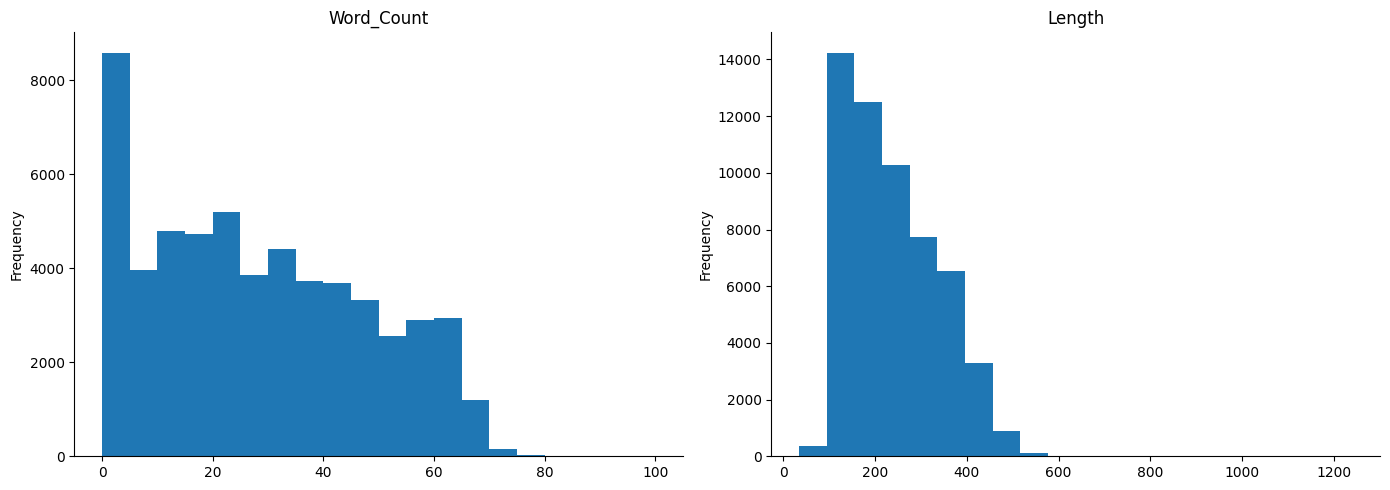

In [ ]:
# word count and lenght of the sequences

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

df['Word_Count'].plot(kind='hist', bins=20, title='Word_Count', ax=axes[0])
axes[0].spines[['top', 'right']].set_visible(False)

df['Length'].plot(kind='hist', bins=20, title='Length', ax=axes[1])
axes[1].spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()


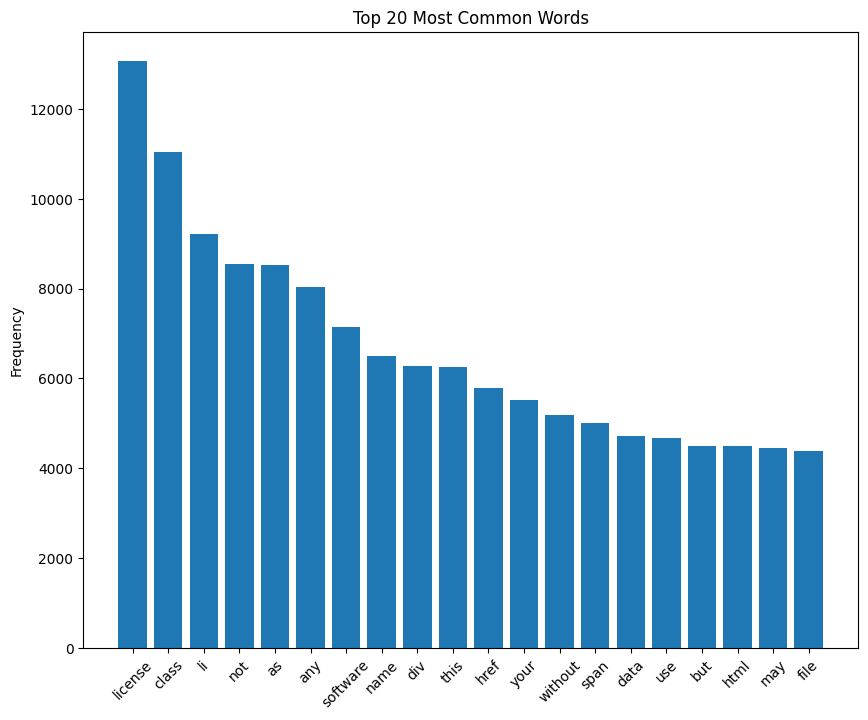

In [ ]:
# most common words

all_words = [word for sentence in df[0] for word in sentence.split() if not word in ['the', '0', 'a', '1', '2', 'i', 's', 'you', 'is']]
word_counts = Counter(all_words)

top_n = 20
most_common_words = word_counts.most_common(top_n)
words, counts = zip(*most_common_words)

plt.figure(figsize=(10, 8))
plt.bar(words, counts)
plt.title('Top 20 Most Common Words')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.show()

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
filtered_sentence = [w for w in all_words if not w.lower() in stop_words]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


[('license', 13058), ('class', 11032), ('li', 9224), ('software', 7141), ('name', 6501), ('div', 6268), ('href', 5796), ('without', 5190), ('span', 5015), ('data', 4725), ('use', 4683), ('html', 4498), ('may', 4448), ('file', 4395), ('type', 4278), ('version', 4001), ('distributed', 3917), ('org', 3788), ('http', 3747), ('string', 3721)]


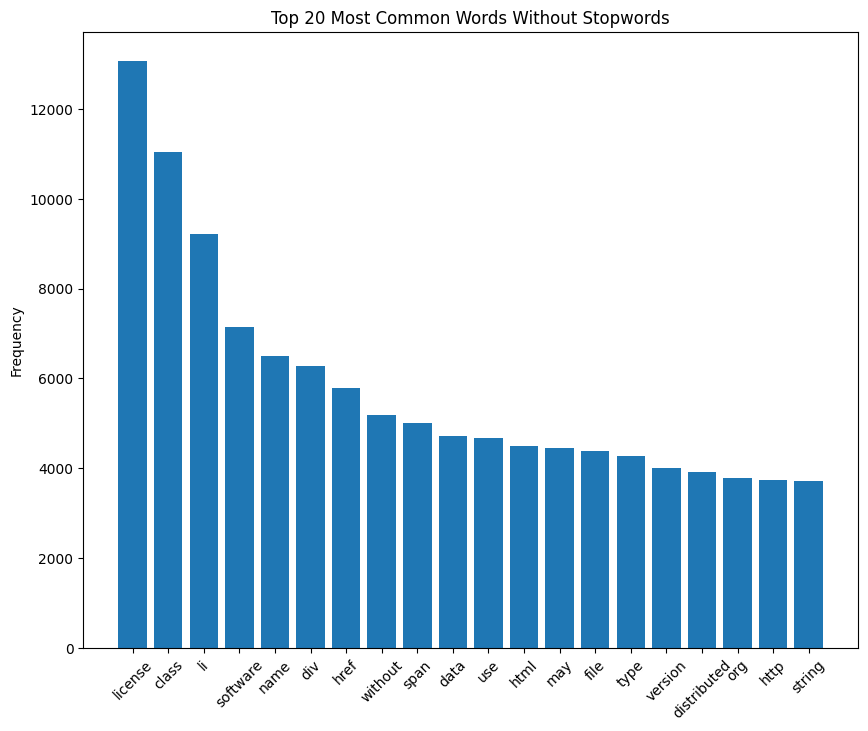

In [ ]:
# without stop words

import matplotlib.pyplot as plt

word_counts = Counter(filtered_sentence)
print(word_counts.most_common(20))

top_n = 20
most_common_words = word_counts.most_common(top_n)
words, counts = zip(*most_common_words)

plt.figure(figsize=(10, 8))
plt.bar(words, counts)
plt.title('Top 20 Most Common Words Without Stopwords')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.show()

In [ ]:
# unique words

unique_words = set(all_words)
print(f'Number of unique words: {len(unique_words)}')

Number of unique words: 109475


In [ ]:
!pip install matplotlib
import matplotlib
import pandas as pd
!pip install ydata_profiling
from ydata_profiling import ProfileReport
import matplotlib
profile = ProfileReport(df, minimal=True)
profile.to_widgets()
profile.to_notebook_iframe()

## 2. Loading the model and prompt it


Now we will try to promt the model with data from file prompts_100 (So, the length of the prompt is 100 tokens). As a prompt we will use the first 50 tokents of the sequence.

In [5]:
data_prompts = data_p.copy()
data_counts = data_c.copy()

In [6]:
model = GPTNeoForCausalLM.from_pretrained("EleutherAI/gpt-neo-125m")
tokenizer = GPT2Tokenizer.from_pretrained("EleutherAI/gpt-neo-125m")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/526M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/357 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

In [7]:
sequence = torch.tensor(torch.from_numpy(data_prompts[100][:50]))
sequence = sequence.reshape(1, -1)
sequence

<ipython-input-7-123d6b58db73>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequence = torch.tensor(torch.from_numpy(data_prompts[100][:50]))


tensor([[ 4320,   546,   783,  1701,   366, 22253,  1643,  4833,  2576,   526,
           366, 41102,   257,  1310,  1643,   588,   345,   526,   366,   818,
           257,  8824, 21749, 45810,   526,   366,  7149,  2863,   345,  1422,
           470,  3285,   326,  1701,   366, 23061,    11,   314, 16521,   526,
           366,    40, 17753,  1057,   284,   262, 16146,   526,   366,  3666]])

In [8]:
output = model.generate(sequence, max_new_tokens=50, min_new_tokens=50, eos_token_id=model.config.eos_token_id,
    pad_token_id=model.config.eos_token_id)
output_d = tokenizer.decode(output[0])

In [9]:
output_d

' dream about now?" "Little bit smaller girl." "Looks a little bit like you." "In a moonpie bikini." "Any chance you didn\'t hear that?" "Listen, I apologize." "I gotta run to the toilet." "My name is Jack." "I\'m a little late." "I\'m sorry." "I\'m sorry." "I\'m sorry." "I\'m sorry." "I\'m sorry." "I\'m sorry." "I\'m sorry." "I\'m sorry'

In [11]:
output_encoded = []
output_decoded = []

for sequence in tqdm.tqdm(data_prompts[:100]):
    sequence = torch.from_numpy(sequence[:50]).reshape(1, -1)
    output = model.generate(sequence, max_new_tokens=50, min_new_tokens=50, eos_token_id=model.config.eos_token_id,
      pad_token_id=model.config.eos_token_id)
    output_d = tokenizer.decode(output[0])

    output_encoded.append(output)
    output_decoded.append(output_d)

  4%|▍         | 4/100 [00:18<07:20,  4.58s/it]


KeyboardInterrupt: 